### Check Python version

In [3]:
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','7'), "You are not running Python 3.7. Make sure to run Python through the course Conda environment."

# HA1 - Cats and dogs

<img src="https://cdn.pixabay.com/photo/2015/05/20/10/03/cat-and-dog-775116_960_720.jpg" alt="Image of cats and dogs" style="width: 500px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It is comprised of 25k colour images of dogs and cats. Our goal with this dataset will be to create a classifier that can tell us if the input image is of a cat or a dog.

## Using your cloud GPU
As a way of helping you speed up the training process, each group gets access to a cloud instance with a GPU. Take a look at the [instructions folder](https://github.com/JulianoLagana/deep-machine-learning/blob/master/instructions/) to understand how to connect to an instance and use our tools there. You're free to use this limited resource as you see fit, but if you spend all your credits, you'll need a late day to obtain more (and you can only do this once).

### Strong recommendation:
In order to make the most out of your GPU hours, first try solving the initial part of this notebook (tasks 0-3) in your own computer (these tasks can be solved on the CPU), and leave most of the available hours for solving tasks 4-5, and refining your best model further (and, if you have the spare hours, experiment a bit!).

### Working efficiently:
Training for several epochs just to have your code break at the last validation step is incredibly frustrating and inefficient. Good practice is to first test long training runs with a much simpler dry-run: a single epoch, a few batches et c.

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance. When experimenting, a single epoch is often enough to tell whether your model setup has improved or not.


Hints:
- If you get errors saying you've exhausted the GPU resources, well, then you've exhausted the GPU resources. However, sometimes that's because `pytorch` didn't release a part of the GPU's memory. If you think your CNN should fit in your memory during training, try restarting the kernel and directly training only that architecture.
- Every group has enough cloud credits to complete this assignment. However, this statement assumes you'll use your resources judiciously (e.g. always try the code first in your machine and make sure everything works properly before starting your instances) and **won't forget to stop your instance after using it,**  otherwise you might run out of credits.
- Before starting, take a look at the images we'll be using. This is a hard task, don't get discouraged if your first models perform poorly (several participants in the original competition didn't achieve an accuracy higher than 60%).
- Solving the [computer labs](https://github.com/JulianoLagana/deep-machine-learning/tree/master/computer-labs) is a good way to get prepared for this assignment.

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [7]:
# YOUR CODE HERE
from pathlib import Path

#Plotting
import matplotlib.pyplot as plt

#Pytorch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

#Helper function for splitting dataset
from sklearn.model_selection import train_test_split

#Fancy progress bar
from tqdm.notebook import tqdm

from pandas import DataFrame
from PIL import Image

---
## 1. Loading the data and preprocessing

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats/data) and download the data from there. You should download both the test and train folders together in one zip file (there is a `Download all` button at the bottom of the page). Unfortunately, you need to create a Kaggle account for this.

**Only necessary for tasks 4-6**: Downloading the data to your local computer is quite straight-forward. Sooner or later you will have to upload the data to the cloud instance and that is a bit more tricky. There are a few ways to do it:

 - Jupyter Notebook upload function. When starting the notebook server with the command `jupyter notebook` you are directed to a main page. In the top right corner there is an upload button.
 - Using [`scp`](https://linuxize.com/post/how-to-use-scp-command-to-securely-transfer-files/) to copy files via an ssh connection.
 - Using the [Kaggle CLI](https://github.com/Kaggle/kaggle-api). We have added it to the conda environment.

For this assignment we will again need data loaders. Like before we need to create a `Dataset` to give as input to a `DataLoader`. 
Fortunately, this type of image data is quite common so we get some help from `pytorch`. We can use [`ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) to create a `Dataset` for our images. As long as our folder structure for the data conforms to the folder structure expected by `ImageFolder`, we can use it right out of the box and the `DataLoader` class will happily accept it as input.

To use `ImageFolder` you should create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      cats        dogs       cats        dogs       cats        dogs       cats        dogs


The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`.
This is just a convenient way of having a smaller dataset to play with for faster prototyping.

We provide you a notebook that shows how to achieve this folder structure (`create_project_notebook_structure.ipynb`), starting from the original `dogs-vs-cats.zip` file that you download from Kaggle. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

For the smaller dataset, we advise you to use 70% of the data as training data (and thereby the remaining 30% for validation data). However, for the larger dataset, you should decide how to split between training and validation.

**What percentage of the larger dataset did you decide to use for training?**

**Your answer:** 80%

**Optional (1 POE):** Did you decide to keep the same ratio split between train and validation sets for the larger dataset? Motivate your decision!


**Your answer:** Since the validation set needs to capture the distribution of the dataset fairly accurately, but the majority of data should go into training, a size of 80% training 20% validation was chosen. It can be reasoned that as the total number of data points has increased, if a 30% validation set accurately captures the distribution of the dataset for a small number of datapoints, the validation set size does not need to increase linearly in order to accurately capture the same distribution.

Fill in the dataset paths (to be used later by your data loaders):

In [8]:
# TODO: Change the directories accordingly
train_path = "train"
val_path = "val"
small_train_path = "small_train"
small_val_path = "small_val"
# YOUR CODE HERE

---
### 1.1 Preprocessing
**(1 POE)** 

Once you have the expected folder structure, create two data loaders for automatically generating batches from the images in your smaller subset of data. It is here we choose how to preprocess the input data. There are multiple reasons for why we preprocess data:

- Some transformations might be needed to actually make the data work with our network (reshaping, permuting dimensions et c.).
- Make the training more efficient by making the input dimensions smaller, e.g. resizing, cropping.
- Artificially expanding the training data through [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/)
- We have some clever idea of how to change the data to make the training process better.

We do not expect you to do data augmentation, but feel free to preprocess the data as you see fit.
Construct an `ImageFolder` dataset like this:

```python
ImageFolder(<path_to_data_folder>, transform=Compose(<list_of_transforms>))
# example:
ImageFolder(Path.cwd() / "small_train", transform=Compose([ToTensor]))
```

Hints:
- Take a look at [`ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) and [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) from the pytorch docs.
- To preprocess the data you can use the built-in pytorch [`Transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The `ImageFolder` dataset provides the data as a python image type. For easy conversion to a `torch.Tensor`, use the [`ToTensor`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) transformation.
- The specified `batch_size` should be chosen so that you train fast but don't run out of memory. You need to figure this out empirically; start small and increase the batch size until you run out of memory.
- The `DataLoader` constructor takes an optional argument `num_workers`, which defaults to `0` if not provided. Setting a higher number creates multiple threads which load batches concurrently. This can speed up training considerably.  
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned built-in pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial. The VGG network that is used later in this assignment requires that images are at least 224x224, but before that use small images to speed up training. The CNN's do surprisingly well on 64x64 or even 32x32 images. Shorter training cycles give your more time to experiment!

We encourage you to explore the data and choose transformations that you believe to be useful. For exploration we provide you with some helper functions to visually compare transformations side by side:

In [9]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of ImageFolder datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.
    
    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)
    
    Args:
        transformations (list(ImageFolder)): list of ImageFolder instances with different transformations
        index (int): Index of the sample in the ImageFolder you wish to compare.
    """
    
    # Here we combine two neat functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, like a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, ImageFolder) for transf in transformations):
        raise TypeError("All elements in the `transformations` list need to be of type ImageFolder")
        
    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)
    
    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]
        
    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title("transf: {}".format(counter))
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

def display_image(axis, image_tensor):
    """Display a tensor as image
    
    Example usage:
        _, axis = plt.subplots()
        some_random_index = 453
        image_tensor, _ = train_dataset[some_random_index]
        display_image(axis, image_tensor)
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


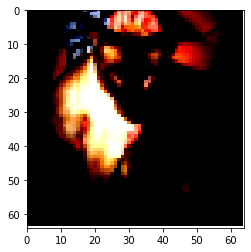

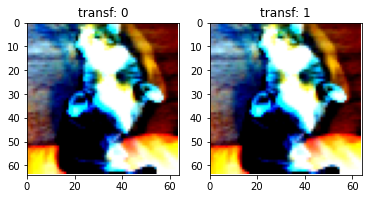

In [10]:
# YOUR CODE HERE
%matplotlib inline

batch_size = 128
pic_size = (64, 64)
trans_vec = transforms.Compose([transforms.Resize(pic_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])

# Small data set
small_train_IF = datasets.ImageFolder(Path(small_train_path), transform = trans_vec)
small_val_IF = datasets.ImageFolder(Path(small_val_path), transform = trans_vec)

# Test code
_, axis = plt.subplots()
some_random_index = 40
image_tensor, _ = small_train_IF[some_random_index]
display_image(axis, image_tensor)

#Comparing transformations 
small_norm = datasets.ImageFolder(Path(small_train_path), transform = transforms.Compose([transforms.Resize(pic_size), 
                                                                                          transforms.ToTensor(), 
                                                                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                                            std=[0.229, 0.224, 0.225])]))
compare_transforms([small_train_IF, small_norm], 5)

#Dataloading
dl_train_small = DataLoader(small_train_IF, batch_size = batch_size, shuffle = True, num_workers = 4)
dl_val_small = DataLoader(small_val_IF, batch_size = batch_size, shuffle = True, num_workers = 4)


train_data_loader = dl_train_small
val_data_loader = dl_val_small

val_dataset = small_val_IF
train_dataset = small_train_IF

**(2 POE)** How did you select transformations, if any? Briefly explain your reasoning:

**Your answer:** To more quickly train the CNN network, the images were downsized to 64 pixels square. In addition, to decrease the variance of the dataset, normalization was applied. The mean and standard deviation of which were taken from the preprocessing of the ImageNet dataset.

---
## 2. Training

**(1 POE)**

Create your first CNN architecture for this task. Start with something as simple as possible, that you're almost sure can get an accuracy better than 50% (we'll improve upon it later).
Naturally, you must also select a loss function and an optimizer.

Hints:

- Training on a CPU is slow and in the beginning you just want to verify that your architecture actually produces a predicition with the correct shape. Make everything you can to speed up the prototyping phase, e.g. train only for a single epoch and make the images ridiculously small.
- Going from the last CNN layer to the final fully connected layer is not trivial. The convolutions produces "3D" output which we can think of as an image with many channels, while the fully connected layer expects a row vector as input. Calculate how many output features the convolutions produce and use `.reshape` to make your tensor fit the fully connected layer. (It is also common to see the `.view` method to do the same thing. They basically do the same thing but have some differences in internal memory management.) *Hint within the hint:* remember that the fully connected layers expects a *batch* of 1D tensors. 


In [11]:
# YOUR CODE HERE
class CatDogClassifierNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #Conv-layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3)
        
        #FC-classifying-layers
        self.fc1 = nn.Linear(6*6*80, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x):
        #Conv-layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        
        #Print here to check size of x before FC layers
        #print(x.size())
        
        x = x.view(-1, 6*6*80)
        #FC-classifier
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


def evaluate_model(val_data_loader, model, loss_fn):
    losses = []
    n_correct = 0
    with torch.no_grad():
        for b_x, b_y in val_data_loader:
            #Check if we have cuda enabled. Will get type error otherwise.
            if torch.cuda.is_available():
                b_x = b_x.cuda()
                b_y = b_y.cuda()
            
            pred = model(b_x)
            loss = loss_fn(pred, b_y)
            losses.append(loss.item())
            
            hard_preds = pred.argmax(dim=1)
            n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()
        val_accuracy = n_correct/len(val_dataset)
        val_avg_loss = sum(losses)/len(losses)    
    
    return val_accuracy, val_avg_loss

def evaluate_epoch(train_data_loader, val_data_loader, model, loss_fn, optimizer):
    losses = []
    n_correct = 0
    #for b_x, b_y in tqdm(train_data_loader):
    for b_x, b_y in train_data_loader:
        if torch.cuda.is_available():
            b_x = b_x.cuda()
            b_y = b_y.cuda()
        
        # Compute predictions and losses
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        # Count number of correct predictions
        hard_preds = pred.argmax(dim=1)
        n_correct += torch.sum(pred.argmax(dim=1) == b_y).item()

        # Backpropagate
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()    
        
    # Compute accuracy and loss in the entire training set
    train_accuracy = n_correct/len(train_dataset)
    train_avg_loss = sum(losses)/len(losses)    
        
    # Compute accuracy and loss in the entire validation set
    val_accuracy, val_avg_loss = evaluate_model(val_data_loader, model, loss_fn)
    
    return train_accuracy, train_avg_loss, val_accuracy, val_avg_loss

Train your model using the two data loaders you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Hints:
- Note that you will need to plot your training and validation losses and accuracies, so make sure that you saved them during training. 

In [12]:
# Any pytorch object (e.g. model, inputs, output, etc.) can 
# be transferred to the current device by running
#       name_of_object.to(device)
# Example:
#       model.to(device)
#
# The following line automatically figures out what device (cpu or gpu)
# you are using and stores the result in `device`.
# Later we can use the `.to(device)` method to move our data or model to the correct device.
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")


# YOUR CODE HERE
model = CatDogClassifierNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

model.to(device)

#Quick switch epochs
epochs = 10

# Create arrays to save all of the metrics throughout training
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Train the model
for epoch in range(epochs):
    print('------ Epoch {} ------'.format(epoch))
    
    #Train one epoch
    train_accuracy, train_avg_loss, val_accuracy, val_avg_loss = evaluate_epoch(train_data_loader, 
                                                                                val_data_loader, 
                                                                                model, 
                                                                                loss_fn, 
                                                                                optimizer)
    
    #Store metrics in arrays
    train_losses.append(train_avg_loss)
    train_accs.append(train_accuracy)
    
    val_losses.append(val_avg_loss)
    val_accs.append(val_accuracy)
    
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))
    

------ Epoch 0 ------
Epoch 0 	Loss: 0.748 	Loss (val): 0.678	Accuracy: 0.51 	Accuracy (val): 0.61
------ Epoch 1 ------
Epoch 1 	Loss: 0.665 	Loss (val): 0.645	Accuracy: 0.60 	Accuracy (val): 0.63
------ Epoch 2 ------
Epoch 2 	Loss: 0.634 	Loss (val): 0.625	Accuracy: 0.65 	Accuracy (val): 0.66
------ Epoch 3 ------
Epoch 3 	Loss: 0.615 	Loss (val): 0.605	Accuracy: 0.66 	Accuracy (val): 0.67
------ Epoch 4 ------
Epoch 4 	Loss: 0.601 	Loss (val): 0.629	Accuracy: 0.68 	Accuracy (val): 0.64
------ Epoch 5 ------
Epoch 5 	Loss: 0.589 	Loss (val): 0.633	Accuracy: 0.69 	Accuracy (val): 0.65
------ Epoch 6 ------
Epoch 6 	Loss: 0.567 	Loss (val): 0.620	Accuracy: 0.71 	Accuracy (val): 0.67
------ Epoch 7 ------
Epoch 7 	Loss: 0.540 	Loss (val): 0.577	Accuracy: 0.73 	Accuracy (val): 0.70
------ Epoch 8 ------
Epoch 8 	Loss: 0.523 	Loss (val): 0.594	Accuracy: 0.73 	Accuracy (val): 0.67
------ Epoch 9 ------
Epoch 9 	Loss: 0.499 	Loss (val): 0.597	Accuracy: 0.76 	Accuracy (val): 0.69


Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

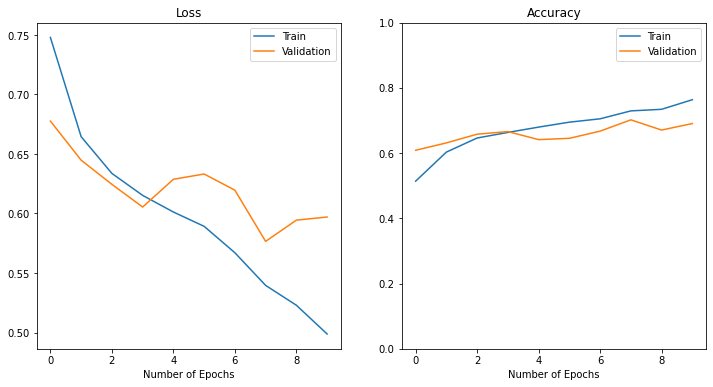

In [13]:
# YOUR CODE HERE
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.ion()

ax[0].clear()
ax[0].plot(train_losses)
ax[0].plot(val_losses)

ax[1].clear()
ax[1].plot(train_accs)
ax[1].plot(val_accs)

# Add legends and labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend(['Train', 'Validation'])

ax[1].set_title('Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend(['Train', 'Validation'])
ax[1].set_ylim([0,1])

# Draw the figure on the screen
fig.canvas.draw()

**(2 POE)** Based on these, what would you suggest for improving your model? Why?

**Your answer:** We are overfitting to the training data, as validation loss goes up the longer we train for. The accuracy trends in the right direction, but it could converge faster. It would seem like the network has too many features, so any improvements should be made with this in mind. The goal is to reduce the number of features overall.

Suggested improvements are to introduce batch normalization and dropout into the net to increase learning speed and combat the overfitting. Since dropout will set some outputs to zero with a certain probability it will force the network to not rely too heavily only on a small set of features. 
The batch normalization should increase the learning speed as the weights of one layer does not have to correct for the mean and variance of the previous layer. 

In addition, the sizes of some layers should be changed and experimented with, in order to learn more general features. 

---
## 3. Improving your model

**(1 POE)** Continue to improve your model architecture by comparing the value of the metrics you're interested in for both the training and validation set. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here. Save the training and validation losses and accuracies. You'll use this later to compare your best model with the one using transfer learning.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to Canvas, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [14]:
# YOUR CODE HERE
class CatDogDeeperClassifierNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #Conv-layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(20)
        
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(40)
        
        self.conv3 = nn.Conv2d(in_channels=40, out_channels=40, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(40)
        
        self.drop = nn.Dropout(p = 0.35)
        
        #FC-classifier layers
        self.fc1 = nn.Linear(6*6*40, 100)
        self.fc2 = nn.Linear(100, 2)
        
    def forward(self, x):
        #Conv-layers 3x(conv-ReLU-BatchNorm-Dropout)
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.drop(x)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.drop(x)
        
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.drop(x)
        
        #Print here to check size before FC layers
        #print(x.size())
        
        x = x.view(-1, 6*6*40)
        x = self.drop(x)
        
        #FC-classifier layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


# Training code
model = CatDogDeeperClassifierNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

model.to(device)

#Quick switch epochs
epochs = 10

# Create arrays to save all of the metrics throughout training
train_losses_mod = []
val_losses_mod = []
train_accs_mod = []
val_accs_mod = []

# Train the model
#for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    print('------ Epoch {} ------'.format(epoch))
    
    #Train one epoch
    train_accuracy, train_avg_loss, val_accuracy, val_avg_loss = evaluate_epoch(train_data_loader, val_data_loader, model, loss_fn, optimizer)
    
    #Store metrics in arrays
    train_losses_mod.append(train_avg_loss)
    train_accs_mod.append(train_accuracy)
    
    val_losses_mod.append(val_avg_loss)
    val_accs_mod.append(val_accuracy)
    
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))
    

------ Epoch 0 ------
Epoch 0 	Loss: 0.941 	Loss (val): 0.679	Accuracy: 0.53 	Accuracy (val): 0.56
------ Epoch 1 ------
Epoch 1 	Loss: 0.666 	Loss (val): 0.665	Accuracy: 0.59 	Accuracy (val): 0.60
------ Epoch 2 ------
Epoch 2 	Loss: 0.646 	Loss (val): 0.649	Accuracy: 0.64 	Accuracy (val): 0.62
------ Epoch 3 ------
Epoch 3 	Loss: 0.626 	Loss (val): 0.666	Accuracy: 0.65 	Accuracy (val): 0.61
------ Epoch 4 ------
Epoch 4 	Loss: 0.612 	Loss (val): 0.638	Accuracy: 0.65 	Accuracy (val): 0.63
------ Epoch 5 ------
Epoch 5 	Loss: 0.590 	Loss (val): 0.614	Accuracy: 0.68 	Accuracy (val): 0.64
------ Epoch 6 ------
Epoch 6 	Loss: 0.575 	Loss (val): 0.601	Accuracy: 0.69 	Accuracy (val): 0.66
------ Epoch 7 ------
Epoch 7 	Loss: 0.562 	Loss (val): 0.610	Accuracy: 0.71 	Accuracy (val): 0.66
------ Epoch 8 ------
Epoch 8 	Loss: 0.540 	Loss (val): 0.600	Accuracy: 0.73 	Accuracy (val): 0.68
------ Epoch 9 ------
Epoch 9 	Loss: 0.530 	Loss (val): 0.603	Accuracy: 0.73 	Accuracy (val): 0.68


Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

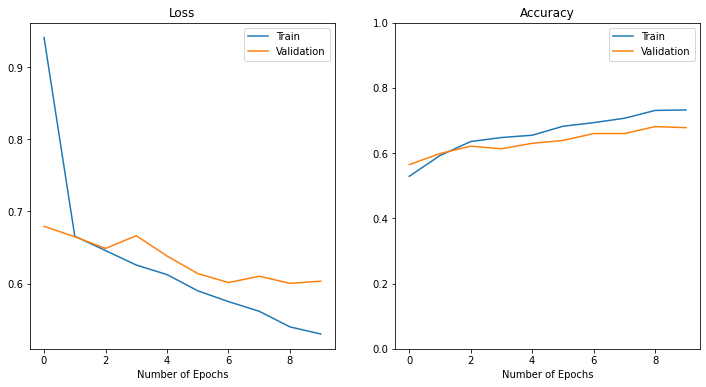

In [15]:
# YOUR CODE HERE
%matplotlib inline
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.ion()

ax[0].clear()
ax[0].plot(train_losses_mod)
ax[0].plot(val_losses_mod)

ax[1].clear()
ax[1].plot(train_accs_mod)
ax[1].plot(val_accs_mod)

# Add legends and labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend(['Train', 'Validation'])

ax[1].set_title('Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend(['Train', 'Validation'])
ax[1].set_ylim([0,1])

# Draw the figure on the screen
fig.canvas.draw()

**(2 POE)** Did your results improve? What problems did your improvements fix? Explain why, or why not. 

**Your answer:** As explained before, the overfitting has been mitigated by the dropout and size changes. Overall it indicates that the classification task does not neccessarily require a very large amount of features.
The validation loss seems to hover around 0.6 but does not seem to trend upwards which would indicate overfitting. 

The batch normalization has increased the convergence rate so that we now have better accuracy already after the first epoch in comparison to the previous network. 

[Save your model](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to disk (the architecture, weights and optimizer state). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual file you create is not relevant to your submission. The code to save the model is given in the cell below. 

In [16]:
# Assuming that you called your model "my_model"
torch.save(model.state_dict(), "my_model")

---
## 4. Transfer Learning

**From now, training on CPU will not be feasible. If your computer has a GPU, try it out! Otherwise, now is the time to connect to your cloud instance**

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected layers + softmax). We'll substitute them with a single fully connected layer, and a classification layer that makes sense for our problem.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the *pretrained* VGG16 model, from the [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html).

In [17]:
# YOUR CODE HERE
vgg_model = models.vgg16(pretrained=True, progress=True)

#Pre processing, VGG takes in images of size 224x224, thus we have to reload our data to fit it better.
batch_size = 64
pic_size = (224, 224)
trans_vec_VGG = transforms.Compose([transforms.Resize(pic_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

small_train_IF_VGG = datasets.ImageFolder(Path(small_train_path), transform = trans_vec_VGG)
small_val_IF_VGG = datasets.ImageFolder(Path(small_val_path), transform = trans_vec_VGG)

#Dataloading
dl_train_small_VGG = DataLoader(small_train_IF_VGG, batch_size = batch_size, shuffle = True, num_workers = 0)
dl_val_small_VGG = DataLoader(small_val_IF_VGG, batch_size = 16, shuffle = False, num_workers = 0)

# Redefine the datasets so the helper functions still work
val_dataset = small_val_IF_VGG
train_dataset = small_train_IF_VGG

Create a new model with the layers you want to add on top of VGG.

*Hint:*
- You can access and modify the top layers of the VGG model with `vgg_model.classifier`, and the remaining layers with `vgg_model.features`.
- You can get the number of output features of `vgg_model.features` with `vgg_model.classifier[0].in_features`

In [18]:
# YOUR CODE HERE
#Get sizes of features
num_features_0_in = vgg_model.classifier[0].in_features
# Delete layers
for i in range(8):
    features = list(vgg_model.classifier.children())[:-i]
    
# Add a new layer
features.extend([nn.Linear(num_features_0_in , 2)])

Now add the new model on top of VGG.

In [19]:
# YOUR CODE HERE
vgg_model.classifier = nn.Sequential(*features)
print(vgg_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=2, bias=True)
)


### 4.1 Using VGG features

Now we're almost ready to train the new model. However, since the top layers of this architecture are being initialized randomly, it's sometimes possible for them to generate large gradients that can wreck the pretraining of the bottom layers. To avoid this, freeze all the VGG layers in your architecture (i.e. signal to the optimizer that these should not be changed during optimization) by setting the attribute `requires_grad` for all parameters `vgg_model.features` to `False`.

In [20]:
# Freeze bottom
# YOUR CODE HERE
for feature in vgg_model.features:
    feature.requires_grad = False

Perform the transfer learning by training the top layers of your model.

In [21]:
model = vgg_model
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#Assume CUDA to be available.
device = torch.device("cuda") 

model.to(device)

#Quick switch epochs
epochs = 5

# Create arrays to save all of the metrics throughout training
train_losses_vgg = []
val_losses_vgg = []
train_accs_vgg = []
val_accs_vgg = []

# Train the model

#for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    print('------ Epoch {} ------'.format(epoch))
    
    #Train one epoch
    train_accuracy, train_avg_loss, val_accuracy, val_avg_loss = evaluate_epoch(dl_train_small_VGG, 
                                                                                dl_val_small_VGG, 
                                                                                model, 
                                                                                loss_fn, 
                                                                                optimizer)
    
    #Store metrics in arrays
    train_losses_vgg.append(train_avg_loss)
    train_accs_vgg.append(train_accuracy)
    
    val_losses_vgg.append(val_avg_loss)
    val_accs_vgg.append(val_accuracy)
    
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

------ Epoch 0 ------
Epoch 0 	Loss: 0.116 	Loss (val): 0.049	Accuracy: 0.96 	Accuracy (val): 0.99
------ Epoch 1 ------
Epoch 1 	Loss: 0.013 	Loss (val): 0.068	Accuracy: 1.00 	Accuracy (val): 0.98
------ Epoch 2 ------
Epoch 2 	Loss: 0.007 	Loss (val): 0.068	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 3 ------
Epoch 3 	Loss: 0.021 	Loss (val): 0.056	Accuracy: 0.99 	Accuracy (val): 0.99
------ Epoch 4 ------
Epoch 4 	Loss: 0.014 	Loss (val): 0.048	Accuracy: 0.99 	Accuracy (val): 0.99


Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

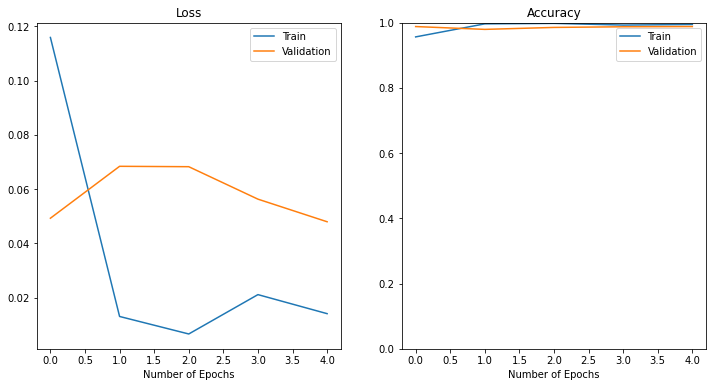

In [22]:
# YOUR CODE HERE
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.ion()

ax[0].clear()
ax[0].plot(train_losses_vgg)
ax[0].plot(val_losses_vgg)

ax[1].clear()
ax[1].plot(train_accs_vgg)
ax[1].plot(val_accs_vgg)

# Add legends and labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend(['Train', 'Validation'])

ax[1].set_title('Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend(['Train', 'Validation'])
ax[1].set_ylim([0,1])

# Draw the figure on the screen
fig.canvas.draw()

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

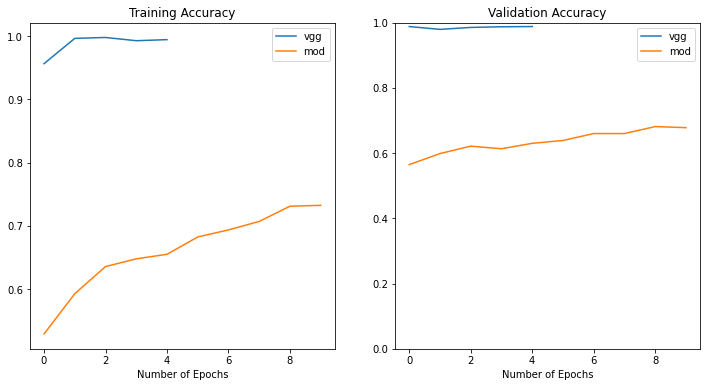

In [23]:
# YOUR CODE HERE
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.ion()

ax[0].clear()
ax[0].plot(train_accs_vgg)
ax[0].plot(train_accs_mod)

ax[1].clear()
ax[1].plot(val_accs_vgg)
ax[1].plot(val_accs_mod)

# Add legends and labels
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend(['vgg', 'mod'])

ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend(['vgg', 'mod'])
ax[1].set_ylim([0,1])

# Draw the figure on the screen
fig.canvas.draw()

**(2 POE)** Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Reflect on whether your comparison is fair or not:

**Your answer:** As expected, VGG worked better for this classification task, since the network is already trained for many classes, including cats and dogs, it is already a very good classifier. Thus using transfer learning for a classification task where the desired classes are a subset of the pretrained classes is shown to be very effective in comparison to starting from scratch each time. 

As for the fairness of the comparison, the argument could be made that the smaller network performs admirably given its size. In addition, it is also able to be trained on a CPU with decent performance for the smaller dataset. 

**(1 POE)** What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** ImageNet dataset contains many more classes than the two we have, and instead of including broad classes like "cat" and "dog", it contains classes for specific breeds.

**Optional (2 POE)** Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** Since the network has already been trained to classify a large dataset with a very high level of specificity, the output from the network before the classifier should already be fairly ordered. That is, the subset of features describing different dog and cat breeds should be more than enough to classify them from one another. Our modified classifier can thus quickly disregard many of its inputs and quickly converge to a very high accuracy and low loss.

**Optional (1 POE)** In which scenario would transfer learning be unsuitable?

**Your answer:** Going the other way, that is training on a smaller dataset, with fewer classes and/or datapoints would be a very bad idea. Since the network would have to be retrained for the newer larger dataset, any benefit of transfer learning is lost. 
Similarly, using transfer learning in a case where the datasets are completely different would be unsuitable as the classes may be very different, thus the network may have to be retrained to better fit the new data. 

Save the model to a file.

In [24]:
torch.save(vgg_model.state_dict(), "trans_learning_top_only")

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers by resetting the `requires_grad` attribute to `True`.

In [25]:
# UnFreeze bottom
# YOUR CODE HERE
for feature in vgg_model.features:
    feature.requires_grad = True

Fine tune the model by training all the layers.

Hint:
- Even though we do have a decent starting point for the optimization, it's still possible that a bad hyper-parameter choice wrecks the preinitialization. Make sure to use a small learning rate for this step.

In [26]:
model = vgg_model
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

device = torch.device("cuda")
model.to(device)

#Quick switch epochs
epochs = 5

# Create arrays to save all of the metrics throughout training
train_losses_vgg_UnFreeze = []
val_losses_vgg_UnFreeze = []
train_accs_vgg_UnFreeze = []
val_accs_vgg_UnFreeze = []

# Train the model

#for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    print('------ Epoch {} ------'.format(epoch))
    
    #Train one epoch
    train_accuracy, train_avg_loss, val_accuracy, val_avg_loss = evaluate_epoch(dl_train_small_VGG, 
                                                                                dl_val_small_VGG, 
                                                                                model, 
                                                                                loss_fn, 
                                                                                optimizer)
    
    
    #Store metrics in arrays
    train_losses_vgg_UnFreeze.append(train_avg_loss)
    train_accs_vgg_UnFreeze.append(train_accuracy)
    
    val_losses_vgg_UnFreeze.append(val_avg_loss)
    val_accs_vgg_UnFreeze.append(val_accuracy)
    
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))
     

------ Epoch 0 ------
Epoch 0 	Loss: 0.001 	Loss (val): 0.049	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 1 ------
Epoch 1 	Loss: 0.000 	Loss (val): 0.054	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 2 ------
Epoch 2 	Loss: 0.000 	Loss (val): 0.056	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 3 ------
Epoch 3 	Loss: 0.000 	Loss (val): 0.057	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 4 ------
Epoch 4 	Loss: 0.000 	Loss (val): 0.059	Accuracy: 1.00 	Accuracy (val): 0.99


How does the model perform, compared to the model trained with frozen layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

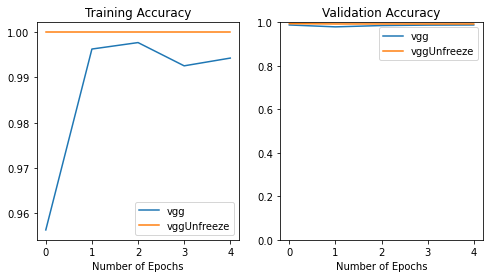

In [27]:
# YOUR CODE HERE
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
plt.ion()

ax[0].clear()
ax[0].plot(train_accs_vgg)
ax[0].plot(train_accs_vgg_UnFreeze)
ax[1].clear()
ax[1].plot(val_accs_vgg)
ax[1].plot(val_accs_vgg_UnFreeze)

# Add legends and labels
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend(['vgg', 'vggUnfreeze'])

ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend(['vgg', 'vggUnfreeze'])
ax[1].set_ylim([0,1])

# Draw the figure on the screen
fig.canvas.draw()

**(1 POE)** Did the model's performance improve? Why (why not)?

**Your answer:** Yes, since the network is now being adjusted to better fit the dataset of cats and dogs that we have, rather than the more general ImageNet dataset. In this case, the weights of the earlier convolutional layers are being retrained to better find the features that are necessary to correctly classify cats and dogs.

Save the model to file.

In [28]:
torch.save(model.state_dict(), "trans_learning_full")

### 4.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here.

In [29]:
# YOUR CODE HERE
vgg_model_temp = models.vgg16(pretrained=True, progress=True)

#Get sizes of features
num_features_0_in = vgg_model_temp.classifier[0].in_features
num_features_6_in = vgg_model_temp.classifier[6].in_features
num_features_0_out = vgg_model_temp.classifier[0].out_features

# Delete layers

features = list(vgg_model.classifier.children())[:0]

# Add layers
features.extend([nn.Linear(num_features_0_in , num_features_0_out), 
                 nn.ReLU(inplace=True), 
                 nn.Dropout(p=0.5, inplace=False), 
                 nn.Linear(num_features_6_in , 2)])

**(1 POE)** How does the model perform, compared to the model trained in step 4.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

------ Epoch 0 ------
Epoch 0 	Loss: 0.000 	Loss (val): 0.092	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 1 ------
Epoch 1 	Loss: 0.000 	Loss (val): 0.098	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 2 ------
Epoch 2 	Loss: 0.000 	Loss (val): 0.099	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 3 ------
Epoch 3 	Loss: 0.000 	Loss (val): 0.101	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 4 ------
Epoch 4 	Loss: 0.000 	Loss (val): 0.102	Accuracy: 1.00 	Accuracy (val): 0.99


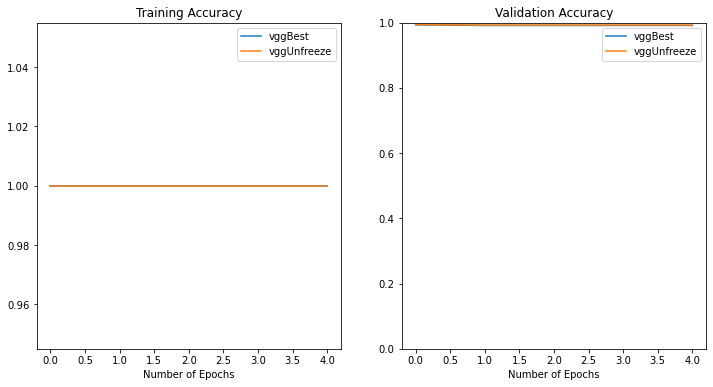

In [30]:
# YOUR CODE HERE
model = vgg_model
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

device = torch.device("cuda")
model.to(device)

#Quick switch epochs
epochs = 5

# Create arrays to save all of the metrics throughout training
train_losses_vgg_imp = []
val_losses_vgg_imp = []
train_accs_vgg_imp = []
val_accs_vgg_imp = []

# Train the model

#for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    print('------ Epoch {} ------'.format(epoch))
    
    #Train one epoch
    train_accuracy, train_avg_loss, val_accuracy, val_avg_loss = evaluate_epoch(dl_train_small_VGG, 
                                                                                dl_val_small_VGG, 
                                                                                model, 
                                                                                loss_fn, 
                                                                                optimizer)
    
    
    #Store metrics in arrays
    train_losses_vgg_imp.append(train_avg_loss)
    train_accs_vgg_imp.append(train_accuracy)
    
    val_losses_vgg_imp.append(val_avg_loss)
    val_accs_vgg_imp.append(val_accuracy)
    
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

# Plotting
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.ion()

ax[0].clear()
ax[0].plot(train_accs_vgg_imp)
ax[0].plot(train_accs_vgg_UnFreeze)
ax[1].clear()
ax[1].plot(val_accs_vgg_imp)
ax[1].plot(val_accs_vgg_UnFreeze)

# Add legends and labels
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend(['vggBest', 'vggUnfreeze'])

ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend(['vggBest', 'vggUnfreeze'])
ax[1].set_ylim([0,1])

# Draw the figure on the screen
fig.canvas.draw()

Save the model to a file.

In [31]:
torch.save(model.state_dict(), "best_trans_learning")

## 5. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data loaders, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [32]:
# YOUR CODE HERE
batch_size = 64
pic_size = (224, 224)
trans_vec_VGG = transforms.Compose([transforms.Resize(pic_size), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])


#VGG Big Dataset 
train_IF_VGG = datasets.ImageFolder(Path(train_path), transform = trans_vec_VGG)
val_IF_VGG = datasets.ImageFolder(Path(val_path), transform = trans_vec_VGG)

dl_train_VGG = DataLoader(train_IF_VGG, batch_size = batch_size, shuffle = True, num_workers = 0)
dl_val_VGG = DataLoader(val_IF_VGG, batch_size = 16, shuffle = True, num_workers = 0)

val_dataset = val_IF_VGG
train_dataset = train_IF_VGG

Train your model using the full data. This optimization might take a long time, so live plotting of some metrics is recommended.

In [33]:
# Set best model here:
model = vgg_model


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

device = torch.device("cuda")
model.to(device)

#Quick switch epochs
epochs = 5

# Create arrays to save all of the metrics throughout training
train_losses_vgg_AllData = []
val_losses_vgg_AllData = []
train_accs_vgg_AllData = []
val_accs_vgg_AllData = []


# Train the model

#for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    print('------ Epoch {} ------'.format(epoch))
    
    #Train one epoch
    train_accuracy, train_avg_loss, val_accuracy, val_avg_loss = evaluate_epoch(dl_train_VGG, 
                                                                                dl_val_VGG, 
                                                                                model, 
                                                                                loss_fn, 
                                                                                optimizer)
    
    
    #Store metrics in arrays
    train_losses_vgg_AllData.append(train_avg_loss)
    train_accs_vgg_AllData.append(train_accuracy)
    
    val_losses_vgg_AllData.append(val_avg_loss)
    val_accs_vgg_AllData.append(val_accuracy)
    
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} '
    display_str += '\tAccuracy (val): {:.2f}'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))
     

------ Epoch 0 ------
Epoch 0 	Loss: 0.040 	Loss (val): 0.026	Accuracy: 0.99 	Accuracy (val): 0.99
------ Epoch 1 ------
Epoch 1 	Loss: 0.012 	Loss (val): 0.026	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 2 ------
Epoch 2 	Loss: 0.005 	Loss (val): 0.029	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 3 ------
Epoch 3 	Loss: 0.002 	Loss (val): 0.031	Accuracy: 1.00 	Accuracy (val): 0.99
------ Epoch 4 ------
Epoch 4 	Loss: 0.001 	Loss (val): 0.035	Accuracy: 1.00 	Accuracy (val): 0.99


How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

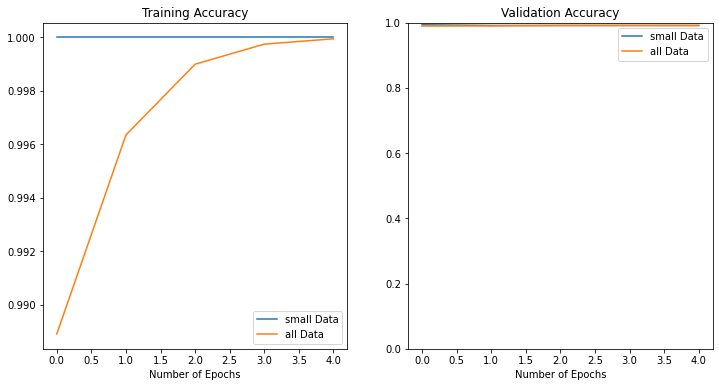

In [34]:
# YOUR CODE HERE
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.ion()

ax[0].clear()
ax[0].plot(train_accs_vgg_imp)
ax[0].plot(train_accs_vgg_AllData)
ax[1].clear()
ax[1].plot(val_accs_vgg_imp)
ax[1].plot(val_accs_vgg_AllData)

# Add legends and labels
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend(['small Data', 'all Data'])

ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend(['small Data', 'all Data'])
ax[1].set_ylim([0,1])

# Draw the figure on the screen
fig.canvas.draw()

**(2 POE)** What can you conclude from these plots? Did you expect what you observe in the plots, explain!

**Your answer:** The plots show that the network trained on the larger dataset is more accurate, which is to be expected as there will be more varying data to learn from in the larger dataset. Thus the model trained on all the data will be better at picking out more generalized features. 

Note: For the final run, the improved net achieved a perfect accuracy within one epoch, thus the statement above regard accuracy, the behaviour of which was observed previously, is technically false. However, as can be seen from the loss of the validation, the network when trained on the small dataset starts overfitting to the training data, thus the network trained on the entire dataset is better at picking out general features.

## 6. Evaluation on test set (optional)

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labeled, so we can't compute any performance metrics ourselves. 

As a bit of fun and to inspire some friendly competition you may instead submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

Hints:
- There is a `sampleSubmission.csv` file included in the zip data. Take a look at it to better understand what is the expected format here.
- `pathlib`'s `Path` class has a `glob` function, which returns the filenames of all files in a given path.
- If you don't know how to create and write to files with Python, Google can help.

In [35]:
# YOUR CODE HERE
df = DataFrame(columns = ['id', 'label'])

for img_path in Path("./test").glob("*.jpg"):
    #Get image and do transformations to make it fit VGG
    img = Image.open(img_path)
    img_trans = trans_vec_VGG(img)
    img_trans.unsqueeze_(0)
    
    #Feed the network and obtain result of classification  
    result = F.softmax(vgg_model(img_trans.to('cuda')), dim = 1)
    #Append dataframe
    filename = img.filename.split('/')[-1]
    
    df = df.append({'id': filename.split('.')[0], 'label': result[0][1].item()},ignore_index=True)

#Save to disk
df.to_csv("test_classification.csv", index=False)

Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, but you can submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) via the "Late submission" button (they use the same data). The Kaggle CLI can be used as well. Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** 0.14971